# Tracking example

This small notebook is here to play with tracking info.

In [2]:
# imports
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
import sys
code_dir = '/camp/lab/znamenskiyp/home/users/blota/code/Calibrations/ScreenCalibration/Python'
if code_dir not in sys.path:
    sys.path.append(code_dir)
import camera_calibration as camcal

In [3]:
# find the data
#data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/AnBl_onix_pilote/tracking/withmouse/')
data_root = Path('/camp/lab/znamenskiyp/data/instruments/raw_data/projects/AnBl_onix_pilote/example_2boxes/rec2')
save_root = Path('/camp/lab/znamenskiyp/home/shared/projects/AnBl_onix_calibration/')
csv_files = {}
dat_files = {}
video_files = {}
for f in data_root.iterdir():
    if f.suffix =='.csv':
        csv_files[f.stem] = f
    elif f.suffix =='.dat':
        dat_files[f.stem] = f
    elif f.suffix =='.avi':
        video_files[f.stem] = f
    else:
        print('unknow suffix: %s'%f.suffix)
        print(f)

In [4]:
# load csv and center all bonsai csv datetime on the same zero
csv_data = {}
zero = None
for k, v in csv_files.items():
    data = pd.read_csv(v, header=None)
    if k.startswith('camera_marecelo'):
        data = data[[data.columns[-1]]]
    if data.shape[1] == 2:
        data.columns = ['camera', 'bonsai']
    else:
        data.columns = ['bonsai']
    data['bonsai'] = pd.to_datetime(data.bonsai)
    if zero is None:
        zero = data.bonsai[0]
    data['bonsai'] = (data.bonsai - zero).dt.total_seconds()
    name = k.split('_timestamps')[0]
    csv_data[name] = data
    print('%s data point for %s'%(len(data), name))

23695 data point for camera_two
20145 data point for camera_three
6449 data point for lighthouse2
73096 data point for camera_marecelo
3867 data point for lighthouse1


In [5]:
# load dat

dat_data = {}
for k, v in dat_files.items():
    name = k.split('_2021')[0]
    if 'ephys' in name:
        data = np.fromfile(v, dtype='int16')
        data = data.reshape([-1, 64])
    elif 'quaternion' in name:
        data = np.fromfile(v, dtype='float')
        data = data.reshape([-1, 4])
    else:
        data = np.fromfile(v, dtype='double')
        data = data.reshape([-1, 3])
    dat_data[name] = data
    print('%s data point for %s'%(data.shape[1], name))

3 data point for lighthouse_matrix1
4 data point for quaternion_matrix
64 data point for pilot_ephys
3 data point for lighthouse_matrix2


In [6]:
# get the videos
vid_data = {}
for k, v in video_files.items():
    name = k.split('_')[1]
    cap = cv2.VideoCapture(str(v))
    vid_data[name] = cap
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('%d frames for %s' % (length, name))

23695 frames for two
73096 frames for marcelo
20145 frames for three


## Calibrate lighthouse

Re-express the lighthouse tracking in proper world coordinates

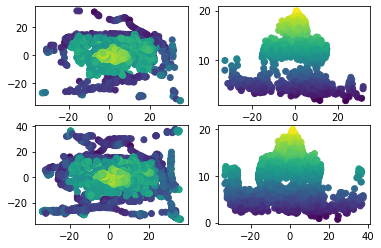

In [7]:
lighthouse_calib = np.load(save_root /  'lighthouse_calibration.npz')

fig = plt.figure()
for ilight in (1, 2):
    raw_data = dat_data['lighthouse_matrix%d'%ilight]
    centered = raw_data - lighthouse_calib['origin']
    rotated = np.array(np.matmul(lighthouse_calib['A_light2world'], centered.T).T)
    dat_data['light%d'%ilight] = rotated
    ax = fig.add_subplot(2,2,ilight*2-1)
    ax.scatter(rotated[:,0], rotated[:,1], c=rotated[:,2])
    ax = fig.add_subplot(2,2,ilight*2)
    ax.scatter(rotated[:,1], rotated[:,2], c=rotated[:,2])

(0.0, 200.0)

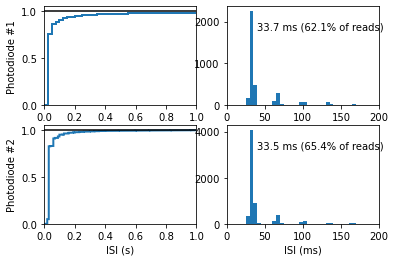

In [8]:
# check how often I have lighthouse data
ts1 = csv_data['lighthouse1'].bonsai.values
ts2 = csv_data['lighthouse2'].bonsai.values
max1 = np.diff(ts1).max()
max2 = np.diff(ts2).max()
tsmax = max(max1,max2)

fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.set_ylabel('Photodiode #1')
ax.axhline(1, color='k')
_ = ax.hist(np.diff(ts1), bins=np.arange(0,max1+0.025,0.025), cumulative=True, histtype='step', density=True, lw=2)
ax.set_xlim([0, 1])
ax = fig.add_subplot(2,2,3)
ax.set_ylabel('Photodiode #2')
ax.axhline(1, color='k')
_ = ax.hist(np.diff(ts2), bins=np.arange(0,max2+0.025,0.01), cumulative=True, histtype='step', density=True, lw=2)
ax.set_xlim([0, 1])

ax.set_xlabel('ISI (s)')
ax = fig.add_subplot(2,2,2)
n, b, p = ax.hist(np.diff(ts1)*1000, bins=np.arange(0,200,5))
m = np.median(np.diff(ts1))
ax.text(40, n.max() * 0.8, '%.1f ms (%.1f%% of reads)' % (m*1000, n.max()/n.sum()*100))
ax.set_xlim([0, 200])
ax = fig.add_subplot(2,2,4)
n, b, p = ax.hist(np.diff(ts2)*1000, bins=np.arange(0,200,5))
m = np.median(np.diff(ts2))
ax.text(40, n.max() * 0.8, '%.1f ms (%.1f%% of reads)' % (m*1000, n.max()/n.sum()*100))
ax.set_xlabel('ISI (ms)')
ax.set_xlim([0, 200])

In [9]:
# For video two, make a dictionary of headstage position for a bunch of frames

# for first recording only
if data_root.stem.endswith('tracking/withmouse/'):
    two_pos = {12300: (713, 400),
               11200: (387, 580),
               11000: (560, 795),
               1004: (690, 910),
               2009: (420, 900),
               3009: (400, 890),
               8009: (1275, 290),
               10400: (225, 1030),
               10550: (1000, 1050),
               10607: (1000, 1050),
               9532: (980, 250),
              }
    # find corresponding tracking point
    assert int(vid_data['two'].get(cv2.CAP_PROP_FRAME_COUNT)) == len(csv_data['camera_two'])

    lighthouse1_time = csv_data['lighthouse1'].bonsai.values
    lighthouse2_time = csv_data['lighthouse2'].bonsai.values


    out = []
    for t, (x, y) in two_pos.items():
        sync_out = {}
        sync_out['cam2_frame'] = t
        sync_out['cam2_xy'] = [x, y]
        frame_timestamp = csv_data['camera_two'].loc[t, 'bonsai']
        sync_out['cam2_ts'] = frame_timestamp
        for name, timeseries in zip(['light1', 'light2'], (lighthouse1_time, lighthouse2_time)):
            index = timeseries.searchsorted(frame_timestamp)
            tdiff = timeseries[index] - frame_timestamp
            if abs(timeseries[index - 1] - frame_timestamp) < tdiff:
                index -= 1
            sync_out[name + '_index'] = index
            sync_out[name + '_ts'] = timeseries[index]
            xyz_data = dat_data['light1'] if name == 'light1' else dat_data['light2']
            sync_out[name + '_xyz'] = xyz_data[index]
        out.append(sync_out)
    out = pd.DataFrame(out)
    out

# Extrinsic calibration

Do it with aruco

In [10]:
calib_extr = {}
aruco_cam = dict()
for cam in ['two', 'three', 'marcelo']:
    aruco_cam[cam] = dict(np.load(save_root / ('aruco_camera_%s.npz'%cam)))

Do it based on manually clicked points

In [11]:
if False:
    two_d = np.array([[690, 632],
                      [775, 740],
                      [988, 579],
                      [902, 475]], dtype=float)
    three_d = np.array([[0,0,0],
                        [55,0,0],
                        [55,90,0], 
                        [0,90,0],
                       ], dtype=float)

    # look at one frame

    frame_number = 10192
    cap = vid_data['two']
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    res, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(gray, origin='lower', vmin=100,vmax=150)
    order = 'osdx'
    for i, p in enumerate(two_d):
        ax.plot(*p, 'k', marker=order[i], ms=10)
        ax.text(*p, s=three_d[i])
    #ax.plot(690, 632, 'ro', mfc='none')
    ax.set_xlim([600,1000])
    ax.set_ylim([300,750])

    calib = np.load(save_root/ 'camera_two_calibration.npz')
    ret, rvec, tvec = cv2.solvePnP(objectPoints=three_d, 
                                   imagePoints=two_d, 
                                   cameraMatrix=calib['mtx'],
                                   distCoeffs=calib['dist'],
                                   flags=cv2.SOLVEPNP_ITERATIVE)

In [12]:
# now project point on a plane to see
calib = np.load(save_root/ 'camera_two_calibration.npz')
rvec = aruco_cam['two']['rvec']
tvec = aruco_cam['two']['tvec']

X,Y = np.meshgrid(np.arange(10)*0.1, np.arange(10)*0.1)
objectPoints = np.zeros([100,1,3])
objectPoints[:,0, 0] = X.flatten() - 1
objectPoints[:,0, 1] = +1.5
objectPoints[:,0, 2] = Y.flatten() - 0
imgpts, jac = cv2.projectPoints(objectPoints, 
                                rvec=rvec, 
                                tvec=tvec,
                                cameraMatrix=calib['mtx'], 
                                distCoeffs=calib['dist'])

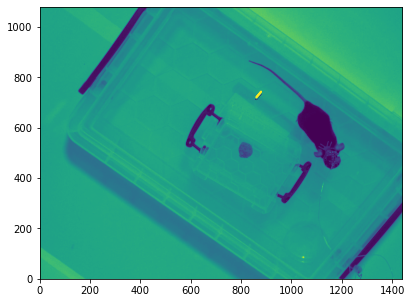

In [13]:
frame_number = 10192
cap = vid_data['two']
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
res, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
ax.imshow(gray, origin='lower')
ax.scatter(imgpts[:,0,0], imgpts[:,0,1], c=Y.flatten(), s=1)

# Find lighthouse origin

I want to find where is the lighthouse origin in the camera coordinates.

I'll do some 3d tracking with the 2 good cameras

In [14]:
# first load camera intrinsic and extrinsic calibration and make projection matrix
calib = dict()
camera_names = ['two', 'three']
for cam in camera_names:
    cal = dict(np.load(save_root/ ('camera_%s_calibration.npz'%cam)))
    cal.update(dict(np.load(save_root / ('aruco_camera_%s.npz'%cam))))
    # create rotation matrix:
    rot, jac = cv2.Rodrigues(cal['rvec'])
    # add translation
    RT = np.hstack([rot, cal['tvec'][0].T])
    # multiply by intrinsic to get projection matrix
    proj = np.matmul(cal['mtx'], RT)
    cal['proj'] = proj
    
    calib[cam] = cal

In [15]:
ts = csv_data['camera_%s'%cam].bonsai.values
okts = ts[(ts > 40.8) & (ts < 48)]
points = dict(frame_times=okts)
for cam in camera_names:
    frame_index = np.zeros(len(points['frame_times']), dtype=int)
    camframe_times = np.zeros_like(points['frame_times'])
    ts = csv_data['camera_%s'%cam].bonsai.values
    for iframe, frame_time in enumerate(points['frame_times']):
        frame_ind = ts.searchsorted(frame_time)
        tdiff = ts[frame_ind] - frame_time
        if np.abs(ts[frame_ind-1] - frame_time) < tdiff:
            frame_ind -= 1
        frame_index[iframe] = frame_ind
        camframe_times[iframe] = ts[frame_ind]
    points['frame_index_%s' % cam] = frame_index
    points['cam_time_%s' % cam] = camframe_times

# also get the corresponding lighthouse tracking
for light in [1,2]:
    light_index = np.zeros(len(points['frame_times']), dtype=int)
    lightframe_times = np.zeros_like(points['frame_times'])
    light_data = np.zeros([len(points['frame_times']), 3])
    ts = csv_data['lighthouse%i'%light].bonsai
    dat = dat_data['light%i'%light]
    for iframe, frame_time in enumerate(points['frame_times']):
        frame_ind = ts.searchsorted(frame_time)
        tdiff = ts[frame_ind] - frame_time
        if np.abs(ts[frame_ind-1] - frame_time) < tdiff:
            frame_ind -= 1
        light_index[iframe] = frame_ind
        lightframe_times[iframe] = ts[frame_ind]
        light_data[iframe,:] = dat[frame_ind]
    points['light_index_%i'% light] = light_index
    points['light_time_%i'% light] = lightframe_times
    points['light_data_%i'% light] = list(light_data)
        
        
points = pd.DataFrame(points)
dt = points.cam_time_two - points.cam_time_three
points = points[np.abs(dt) < 0.5/1000].reset_index()

for cam in camera_names:
    points['%s_x'%cam] = 0
    points['%s_y'%cam] = 0

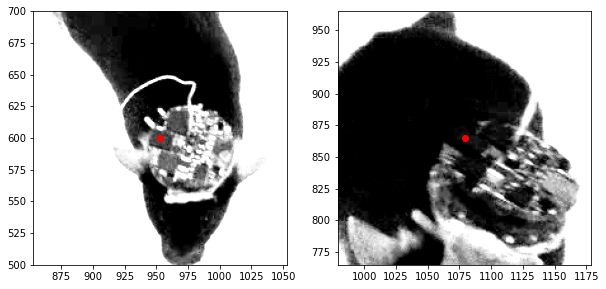

In [16]:
# Now select the same point in a bunch of frames
points.loc[0, 'two_x'], points.loc[0, 'two_y']     = [935, 617]
points.loc[0, 'three_x'], points.loc[0, 'three_y'] = [1052, 866]
points.loc[1, 'two_x'], points.loc[1, 'two_y']     = [953, 600]
points.loc[1, 'three_x'], points.loc[1, 'three_y'] = [1079, 865]
points.loc[2, 'two_x'], points.loc[2, 'two_y']     = [967, 575]
points.loc[2, 'three_x'], points.loc[2, 'three_y'] = [1103, 857]
points.loc[3, 'two_x'], points.loc[3, 'two_y']     = [968, 566]
points.loc[3, 'three_x'], points.loc[3, 'three_y'] = [1110, 854]
points.loc[30, 'two_x'], points.loc[30, 'two_y']     = [562, 510]
points.loc[30, 'three_x'], points.loc[30, 'three_y'] = [417, 972]
points.loc[38, 'two_x'], points.loc[38, 'two_y']     = [523, 668]
points.loc[38, 'three_x'], points.loc[38, 'three_y'] = [384, 1080]
points.loc[10, 'two_x'], points.loc[10, 'two_y']     = [787, 258]
points.loc[10, 'three_x'], points.loc[10, 'three_y'] = [647, 462]
points.loc[20, 'two_x'], points.loc[20, 'two_y']     = [640, 278]
points.loc[20, 'three_x'], points.loc[20, 'three_y'] = [397, 536]


ipts = 1
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
vmax = dict(two=50, three=40)
for iax, cam in enumerate(camera_names):
    cap = vid_data[cam];    frame_index = points.loc[ipts, 'frame_index_%s'%cam]
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1);    res, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    axes[iax].imshow(gray, origin='lower', cmap='Greys_r', vmin=0, vmax=vmax[cam])
    x,y = points.loc[ipts, ['%s_x'%cam, '%s_y'%cam]]
    if x!=0 or y !=0:
        axes[iax].plot(x, y, 'ro')
        axes[iax].set_ylim(y + np.array([-100,100]))
        axes[iax].set_xlim(x + np.array([-100,100]))

In [17]:
# find 3d coordinates by triangulation
proj_pts_two = np.vstack([points.two_x.values, points.two_y.values])
proj_pts_three = np.vstack([points.three_x.values, points.three_y.values])

# remove zeros
valid_pts = proj_pts_two[0,:] != 0
assert np.all(valid_pts == (proj_pts_three[0,:] != 0))
proj_pts_two = np.array(proj_pts_two[:, valid_pts], dtype=float)
proj_pts_three = np.array(proj_pts_three[:, valid_pts], dtype=float)
assert proj_pts_three.shape[1] == proj_pts_two.shape[1]



# triangulate
projected_4d = cv2.triangulatePoints(calib['two']['proj'], calib['three']['proj'], proj_pts_two, proj_pts_three)

# Points are in x,y,z,w, divide the first x,y,z by w
projected = projected_4d[:3,:] / projected_4d[3,:]

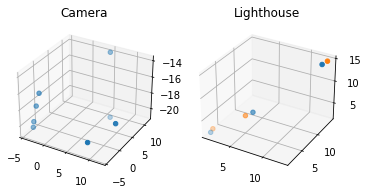

In [18]:
# I know have two sets of 3d point (3 sets if we count the 2 lighthouses)
l1 = np.vstack(points.loc[valid_pts, 'light_data_1'].values)
l2 = np.vstack(points.loc[valid_pts, 'light_data_2'].values)

fig = plt.figure()
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_title('Camera')
ax.scatter(projected[0,:],projected[1,:],projected[2,:])

ax = fig.add_subplot(1,2,2, projection='3d')
ax.set_title('Lighthouse')
ax.scatter(l1[0,:],l1[1,:],l1[2,:])
ax.scatter(l2[0,:],l2[1,:],l2[2,:])

In [19]:
# use function from https://github.com/nghiaho12/rigid_transform_3D/blob/master/rigid_transform_3D.py
# to make the registration easy
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

[[ 1.15521482]
 [-0.9285945 ]
 [-4.28659129]]
[[ 0.79785131]
 [-0.29011401]
 [-4.35907321]]


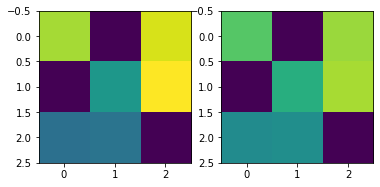

In [20]:
R1, t1 = rigid_transform_3D(l1.T, projected) 
R2, t2 = rigid_transform_3D(l2.T, projected) 

Rm = (R1 + R2) / 2
tm = (t1 + t2 )/ 2
print(t1)
print(t2)

fig, axes = plt.subplots(1,2)
axes[0].imshow(R1, vmin=R1.mean(), vmax=R1.max())
axes[1].imshow(R2, vmin=R1.mean(), vmax=R1.max())

In [21]:
# let's rotate the tracking data to the camera data

light1incamera = np.matmul(Rm, dat_data['light1'].T ) + tm
light2incamera = np.matmul(Rm, dat_data['light2'].T ) + tm

lightincamera =[light1incamera.T, light2incamera.T]
lightinworld = [dat_data['light1'], dat_data['light2']]

In [ ]:
# and plot it on the movie
camera = 'three'

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = None


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cap = vid_data[camera]
frame_tss = csv_data['camera_%s'%camera]
light_tss = [csv_data['lighthouse%i'%il].bonsai.values for il in [1,2]]


kernel = np.ones([12,12], dtype=int)

def add_dot(frame, xy, kernel, color=(255, 0, 0)):
    xs, ys = np.where(kernel)
    xs += xy[0]
    ys += xy[1]
    for x, y in zip(xs, ys):
        if (0<=x<frame.shape[1]) and (0<=y<frame.shape[0]):
            frame[y, x] = color
    return frame

print('%d frames' % len(frame_tss))
for frame_index in range(0, len(frame_tss)):
    if out is None:
        out = cv2.VideoWriter(str(save_root / ('output_tracking_%s.mp4'%camera)), fourcc, 60.0, 
                              (frame.shape[1],frame.shape[0]))


    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
    assert cap.isOpened()
    frame_timestamp = frame_tss.bonsai[frame_index]
    res, frame = cap.read()


    ax.imshow(frame, origin='lower')

    light_indices = [0,0]
    for il in range(2):
        tss = light_tss[il]
        light_index = tss.searchsorted(frame_timestamp)
        tdiff = tss[light_index] - frame_timestamp
        if abs(tss[light_index - 1] - frame_timestamp) < tdiff:
            light_index -= 1
        tdiff = tss[light_index] - frame_timestamp
        color = (255, 0, 125*il) if tdiff > 0.2 else (0, 255, 0)

        light3d = lightincamera[il][light_index]
        # project on 2D
        lightonscreen, jac = cv2.projectPoints(light3d[np.newaxis,np.newaxis,:],
                                          calib[camera]['rvec'],
                                          calib[camera]['tvec'], 
                                          calib[camera]['mtx'], 
                                          calib[camera]['dist'])
        ax.plot(lightonscreen[0,0,0], lightonscreen[0,0,1], color=np.array(color)/255, marker='o')
        xy = np.array(np.round(lightonscreen[0,0,:]), dtype=int)
        frame = add_dot(frame, xy, kernel, color)
    out.write(frame)
    if frame_index % 100 == 0:
        print('Doing frame %d' % frame_index)
out.release()

20145 frames
Doing frame 0
Doing frame 100
Doing frame 200
Doing frame 300
Doing frame 400
Doing frame 500
Doing frame 600
Doing frame 700
Doing frame 800
Doing frame 900
Doing frame 1000
Doing frame 1100
Doing frame 1200
Doing frame 1300
Doing frame 1400
Doing frame 1500
Doing frame 1600
Doing frame 1700
Doing frame 1800
Doing frame 1900
Doing frame 2000
Doing frame 2100
Doing frame 2200
Doing frame 2300
Doing frame 2400
Doing frame 2500
Doing frame 2600
Doing frame 2700
Doing frame 2800
Doing frame 2900
Doing frame 3000
Doing frame 3100
Doing frame 3200
Doing frame 3300
Doing frame 3400
Doing frame 3500
Doing frame 3600
Doing frame 3700
Doing frame 3800
Doing frame 3900
Doing frame 4000
Doing frame 4100
Doing frame 4200
Doing frame 4300
Doing frame 4400
Doing frame 4500
Doing frame 4600
Doing frame 4700
Doing frame 4800
Doing frame 4900
Doing frame 5000
Doing frame 5100
Doing frame 5200
Doing frame 5300
Doing frame 5400
Doing frame 5500
Doing frame 5600
Doing frame 5700
Doing frame 5

In [ ]:
lightonscreen

In [ ]:

dist2origin = np.sum(np.abs(dat_data['light2'][:,:2]), axis=1)
lindex_min = dist2origin.argmin()
pts_min = dat_data['light2'][lindex_min]
print(pts_min)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.axvline(lindex_min, color='k')
ax.plot(dist2origin)

# find the corresponding frame

ts_lightmin = csv_data['lighthouse2'].bonsai.loc[lindex_min]
frame_index = csv_data['camera_two'].bonsai.values.searchsorted(ts_lightmin)
tdiff = csv_data['camera_two'].bonsai.loc[frame_index] - ts_lightmin
if np.abs(csv_data['camera_two'].bonsai.loc[frame_index-1] - ts_lightmin) < tdiff:
    frame_index -= 1

cap = vid_data['two']
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)
res, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

ax = fig.add_subplot(1,2,2)
ax.imshow(frame)

objectPoints = np.zeros([100,1,3])
objectPoints[:,0,2] = np.arange(100) /100 *30
imgpts, jac = cv2.projectPoints(objectPoints, 
                                rvec=rvec, 
                                tvec=tvec,
                                cameraMatrix=calib['mtx'], 
                                distCoeffs=calib['dist'])
ax.scatter(imgpts[:,0,0], imgpts[:,0,1], c=np.arange(100),s=1)
imgpts, jac = cv2.projectPoints(objectPoints=np.array([[[0,0,pts_min[2]]]]), 
                                rvec=rvec, 
                                tvec=tvec,
                                cameraMatrix=calib['mtx'], 
                                distCoeffs=calib['dist'])
ax.plot(imgpts[0,0,0], imgpts[0,0,1], 'ro')

actual_pts = [797, 445]
ax.plot(actual_pts[0], actual_pts[1], 'go')

In [ ]:
# write full video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None

cap = vid_data['two']
frame_tss = csv_data['camera_two']
light2_tss = csv_data['lighthouse2'].bonsai.values

kernel = np.ones([12,12], dtype=int)

def add_dot(frame, xy, kernel, color=(255, 0, 0)):
    xs, ys = np.where(kernel)
    xs += xy[0]
    ys += xy[1]
    for x, y in zip(xs, ys):
        if (0<=x<frame.shape[1]) and (0<=y<frame.shape[0]):
            frame[y, x] = color
    return frame
    
cap.set(cv2.CAP_PROP_POS_FRAMES, 0-1)
assert cap.isOpened()
for frame_index, frame_timestamp in enumerate(frame_tss.bonsai):
    res, frame = cap.read()
    if out is None:
        out = cv2.VideoWriter('output.mp4', fourcc, 20.0, 
                              (frame.shape[1],frame.shape[0]))
    light2_index = light2_tss.searchsorted(frame_timestamp)
    if light2_index == len(light2_tss):
        frame_index += 1
        continue
    tdiff = light2_tss[light2_index] - frame_timestamp
    if abs(light2_tss[light2_index - 1] - frame_timestamp) < tdiff:
        light2_index -= 1
    tdiff = light2_tss[light2_index] - frame_timestamp
    color = (255, 0, 0) if tdiff > 0.2 else (0, 255, 0)
    xy = pred_xylight2[light2_index]
    xy = np.array(np.round(xy), dtype=int)
    frame = add_dot(frame, xy, kernel, color)
    out.write(frame)
    if frame_index % 1000 == 0:
        print('Doing frame %d' % frame_index)
out.release()
print(out.isOpened())
out = None

In [ ]:
cap = cv2.VideoCapture('output.mp4')
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length)